**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[이론 + 실습]** Clip 02. LangGraph 필수 구성요소

## State (상태)

State 는 Agent의 현재 상태를 나타내는 데이터 구조이며, 주로 `TypedDict`, Pydantic `BaseModel` 입니다.


### 1. `TypedDict` , Pydantic `BaseModel` 이해하기

In [ ]:
from typing import TypedDict

class User(TypedDict):
    id: int
    name: str
    email: str

user1: User = {
    'id': 1,
    'name': 'nayeon_park',
    'email': 'uoahvu@gmail.com'
}
print(user1)

{'id': 1, 'name': 'nayeon_park', 'email': 'uoahvu@gmail.com'}


In [ ]:
user1: User = {
    'id': 1,
    'name': 123,
    'email': 'uoahvu@gmail.com'
}
print(user1)

{'id': 1, 'name': 123, 'email': 'uoahvu@gmail.com'}


In [ ]:
from pydantic import BaseModel

class User(BaseModel):
    id: int
    name: str
    email: str

user_data = {
    'id': 1,
    'name': 'nayeon_park',
    'email': 'uoahvu@gmail.com'
}

user1 = User(**user_data)
print(user1)

id=1 name='nayeon_park' email='uoahvu@gmail.com'


In [ ]:
user_data = {
    'id': 1,
    'name': 123,
    'email': 'uoahvu@gmail.com'
}

user = User(**user_data)
print(user)

ValidationError: 1 validation error for User
name
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type

- 잘못된 데이터 타입이라면 오류 메시지를 반환

### 2. 상태 - Graph Schema 지정하기

State(상태) 라는 것은 **그래프의 스키마**와 상태에 업데이트를 적용하는 방법을 지정하는 **리듀서 함수**로 구성됨

- 에이전트를 구현하게 될 때, <u>**에이전트가 가지고 있어야 할 정보**</u>를 상태를 통해 업데이트 해주는 작업을 진행

- 아래 예시에서는 기본적으로 사용자의 질문과 답변을 정해진 데이터 구조(State)에 맞춰 입력 받고 반환하는 것

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# 입력을 위한 스키마 정의
class InputState(TypedDict):
    question: str


# 출력을 위한 스키마 정의
class OutputState(TypedDict):
    answer: str


# 입력과 출력을 합한 종합 스키마 정의
class OverallState(InputState, OutputState):
    pass

In [ ]:
# 입력을 처리하고 답변을 생성하는 노드 정의
def answer_node(state: InputState):
    # Example answer and an extra key
    return {"answer": "bye", "question": state["question"]} # 상태 업데이트


graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
graph_builder.add_node(answer_node)  # 답변 노드 추가
graph_builder.add_edge(START, "answer_node")  # 시작 엣지 추가
graph_builder.add_edge("answer_node", END)  # 끝 엣지 추가
graph = graph_builder.compile()  # Compile the graph

# 입력 invoke 및 결과 출력
print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


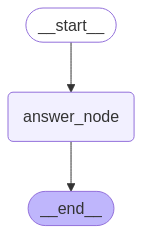

In [ ]:
graph

### 3. 상태 - Reducer 지정하기

리듀서(Reducer)는 노드의 업데이트가 State(상태)에 적용되는 방식을 지정하는 함수


1 ) 리듀서가 지정되지 않은 경우

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    value1: int
    value2: list[str]

2 ) 리듀서가 지정된 경우(`operator.add`)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    value1: int
    value2: Annotated[list[str], add]

3 ) 리듀서가 지정된 경우(`custom add`)

In [ ]:
from typing_extensions import Annotated
from typing_extensions import TypedDict

def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    value1: int
    value2: Annotated[list[str], add]

4 ) 리듀서가 지정된 경우(`add_messages`)


- [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

    - 사용 예시

        ```python
        msgs1 = [HumanMessage(content="Hello", id="1")]
        msgs2 = [AIMessage(content="Hi there!", id="2")]
        add_messages(msgs1, msgs2)
        ```

In [ ]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Nodes

노드는 Agent가 수행하는 논리를 구현하는 함수로 표현됨

### 1. 노드를 추가하는 방법

In [ ]:
from langgraph.graph import StateGraph

builder = StateGraph(dict)


def my_node(state: dict):
    return {"results": f"Hello, {state['input']}!"}


def my_other_node(state: dict):
    return state


builder.add_node("my_node", my_node)
builder.add_node("other_node", my_other_node)

### 2. 노드의 기능을 구현하는 방법

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from operator import add

class State(TypedDict):
    messages: Annotated[list[str], add]


graph = StateGraph(State)

In [ ]:
def chatbot(state: State):
    answer = "안녕하세요! 무엇을 도와드릴까요?"
    print("Answer : ", answer)

    return {"messages": [answer]}


graph.add_node("chatbot", chatbot)

In [ ]:
graph.add_edge(START, "chatbot")
graph.add_edge("chatbot", END)
graph = graph.compile()

In [ ]:
graph.invoke({"messages": ["안녕!"]})

Answer :  안녕하세요! 무엇을 도와드릴까요?


{'messages': ['안녕!', '안녕하세요! 무엇을 도와드릴까요?']}

## Edges

- 기본 엣지 (Normal Edges): 한 노드에서 다음 노드로 바로 이동

    ```python
    graph.add_edge("node_a", "node_b")
    ```


### Routing

라우팅이란, **입력을 분류하고 후속 작업으로 안내하는 과정**으로 다음으로 진행되어야 할 스텝을 결정하여 보내주는 것

![image.png](attachment:image.png)

- 조건부 엣지 (Conditional Edges): 다음으로 이동할 노드를 결정하는 함수를 호출하여 결과에 따라 이동

In [ ]:
class State(TypedDict):
    input: str
    output: str

In [ ]:
router_builder = StateGraph(State)

In [ ]:
def routing_function(state: State):
    if state["input"] == "isroute":
        return True
    return False

In [ ]:
router_builder.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})

- 진입점 (Entry Point): 사용자 입력이 도착하면 호출할 노드

    ```python
    from langgraph.graph import START

    graph.add_edge(START, "node_a")
    ```





- 조건부 진입점 (Conditional Entry Point): 사용자 입력이 도착하면 호출할 노드를 결정하는 함수를 호출하여 결과에 따라 이동

    ```python
    graph.add_conditional_edges(START, routing_function, {True: "node_b", False: "node_c"})
    ```